In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from gradcam import make_gradcam_heatmap, display_heatmap, load_images

In [2]:
MODEL_PATH = "../models/baseline_model.keras"
COVID_DIR = "../data/processed/test/COVID/"
NORMAL_DIR = "../data/processed/test/NORMAL/"
IMG_SIZE = (224, 224)
LAST_CONV_LAYER_NAME = "conv2d_35"
PREDICTION_THRESHOLD = 0.5

In [3]:
def get_image_paths(data_dir):
    """
    get image paths for a given data directory

    params
    ------
    data_dir: str
        path to the data directory

    returns
    -------
    list
        list of full image paths
    """
    paths = []
    if not os.path.isdir(data_dir):
        print(f"warning: directory not found {data_dir}")
        return paths
    for fname in os.listdir(data_dir):
        if fname.lower().endswith((".png", ".jpg", ".jpeg")):
            paths.append(os.path.join(data_dir, fname))
    return paths

In [4]:
def predict_and_classify(model, image_paths, actual_label):
    """
    make predictions for images and classify results

    params
    ------
    model: tf.keras.Model
        trained keras model
    image_paths: list
        list of image paths
    actual_label: int
        the true label for this set of images (0 for covid, 1 for normal - based on alphabetical order)

    returns
    -------
    dict
        dictionary containing lists of paths for tp, fp, tn, fn
    """
    results = {"tp": [], "fp": [], "tn": [], "fn": []}
    print(
        f"predicting {len(image_paths)} images with actual label {'COVID' if actual_label == 0 else 'NORMAL'}"
    )

    # process images one by one for simplicity, batching could optimize
    for img_path in image_paths:
        img_batch, _ = load_images([img_path], IMG_SIZE)
        prediction = model.predict(img_batch, verbose=0)[0][0]
        predicted_label = 1 if prediction >= PREDICTION_THRESHOLD else 0

        # classify based on actual_label (0=COVID, 1=NORMAL)
        # TP: Actual COVID (0), Predicted COVID (0) -> Not applicable here directly
        # FN: Actual COVID (0), Predicted NORMAL (1)
        # TN: Actual NORMAL (1), Predicted NORMAL (1)
        # FP: Actual NORMAL (1), Predicted COVID (0)

        if actual_label == 0:  # actual is covid
            if predicted_label == 0:
                results["tp"].append(img_path)  # classified as covid (true positive)
            else:
                results["fn"].append(img_path)  # classified as normal (false negative)
        else:  # actual is normal (1)
            if predicted_label == 1:
                results["tn"].append(img_path)  # classified as normal (true negative)
            else:
                results["fp"].append(img_path)  # classified as covid (false positive)

    print(
        f"  results: tp={len(results['tp'])}, fn={len(results['fn'])}, tn={len(results['tn'])}, fp={len(results['fp'])}"
    )
    return results

In [5]:
def generate_heatmap_for_image(model, img_path):
    """
    generate and display grad-cam heatmap for a single image

    params
    ------
    model: tf.keras.Model
        loaded keras model
    img_path: str
        path to the image file
    """
    print(f"generating heatmap for: {os.path.basename(img_path)}")

    image_batch, display_batch = load_images([img_path], IMG_SIZE)
    heatmap = make_gradcam_heatmap(image_batch.numpy(), model, LAST_CONV_LAYER_NAME)

    # display heatmap (display_heatmap handles figure creation and showing)
    display_heatmap(display_batch.numpy()[0], heatmap, alpha=0.4)

In [6]:
model = keras.models.load_model(MODEL_PATH)

In [7]:
covid_paths = get_image_paths(COVID_DIR)
normal_paths = get_image_paths(NORMAL_DIR)

In [8]:
all_results = {"tp": [], "fp": [], "tn": [], "fn": []}

covid_results = predict_and_classify(model, covid_paths, actual_label=0)
all_results["tp"].extend(covid_results["tp"])
all_results["fn"].extend(covid_results["fn"])

normal_results = predict_and_classify(model, normal_paths, actual_label=1)
all_results["tn"].extend(normal_results["tn"])
all_results["fp"].extend(normal_results["fp"])

predicting 100 images with actual label COVID
  results: tp=95, fn=5, tn=0, fp=0
predicting 100 images with actual label NORMAL
  results: tp=0, fn=0, tn=78, fp=22


In [9]:
# select the first image for each category
sampled_paths = {category: paths[0] for category, paths in all_results.items()}


generating heatmaps...

Displaying: True Positive (COVID)
generating heatmap for: COVID-2078.png
input array shape: (1, 224, 224, 3)


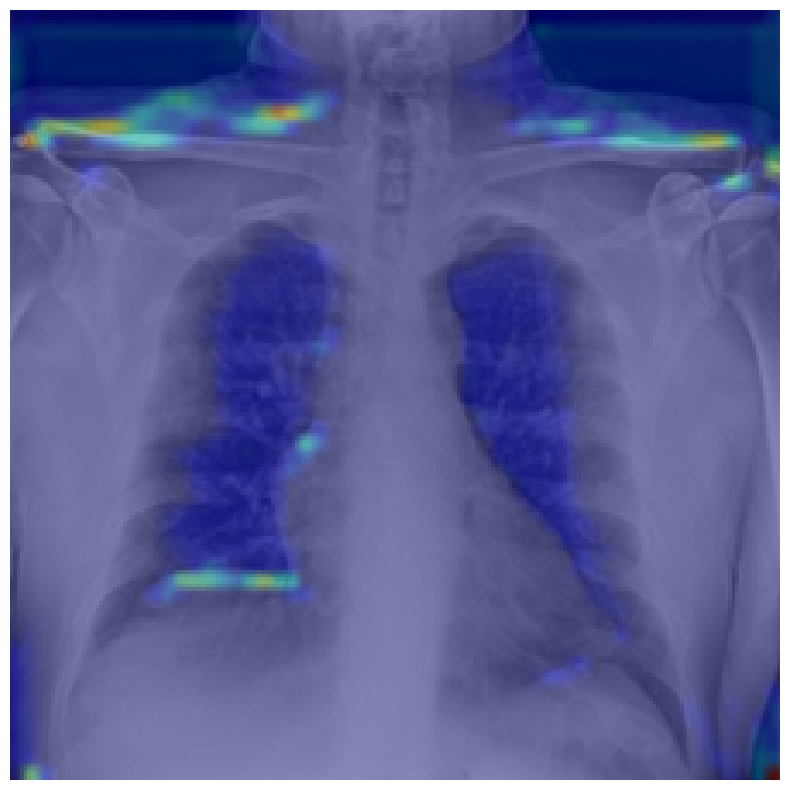


Displaying: False Positive (NORMAL as COVID)
generating heatmap for: Normal-2085.png
input array shape: (1, 224, 224, 3)


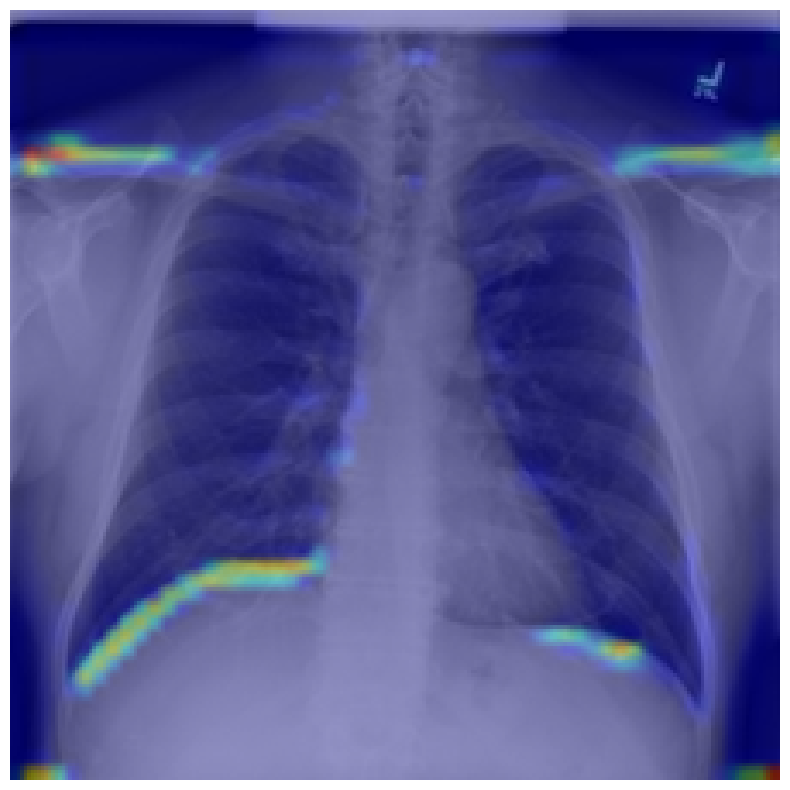


Displaying: True Negative (NORMAL)
generating heatmap for: Normal-2086.png
input array shape: (1, 224, 224, 3)


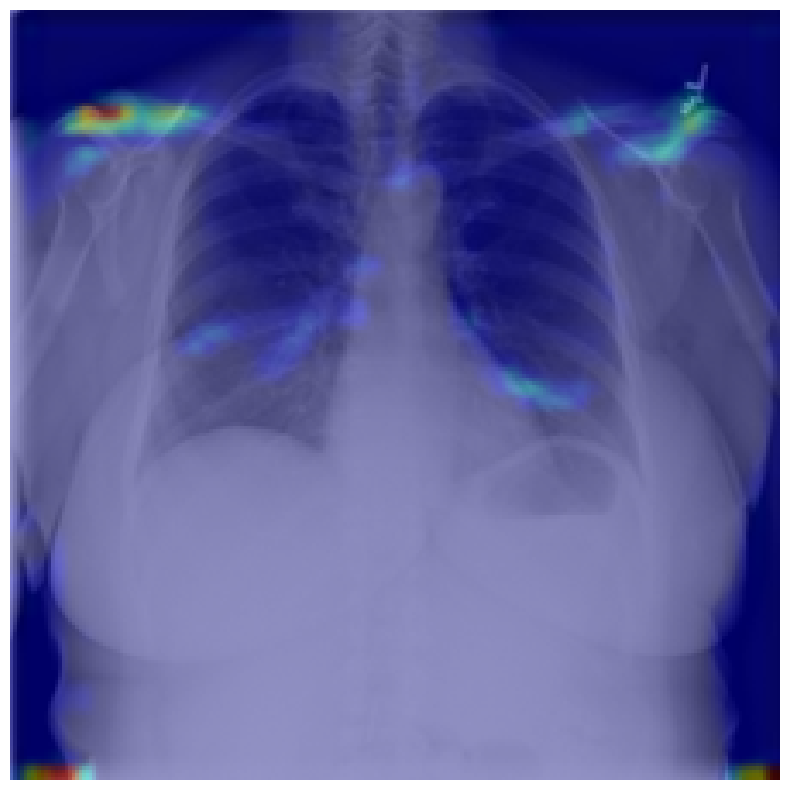


Displaying: False Negative (COVID as NORMAL)
generating heatmap for: COVID-2044.png
input array shape: (1, 224, 224, 3)


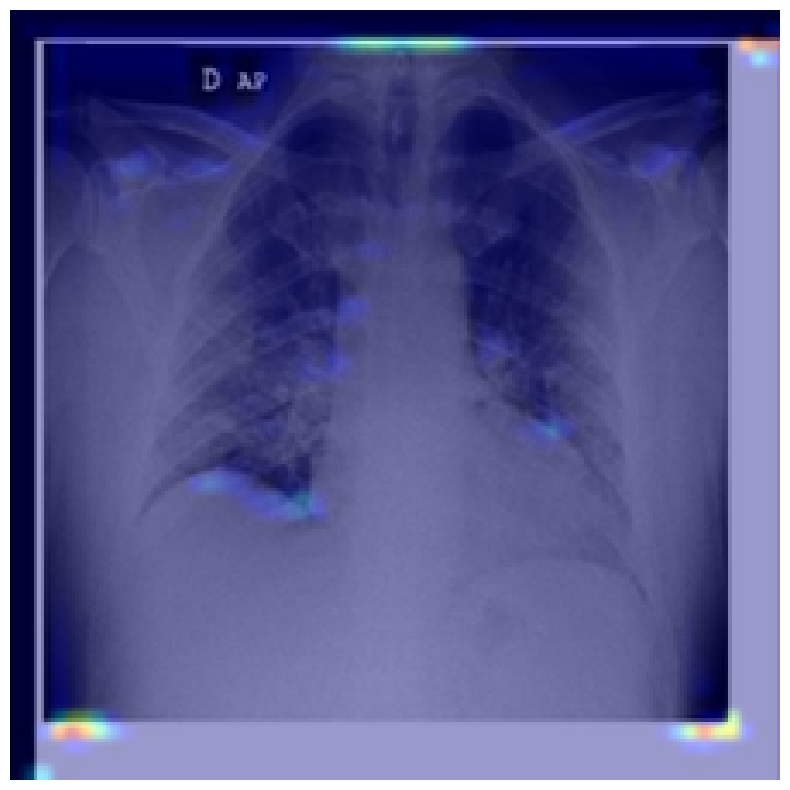

In [10]:
print("\ngenerating heatmaps...")
category_map = {
    "tp": "True Positive (COVID)",
    "fn": "False Negative (COVID as NORMAL)",
    "tn": "True Negative (NORMAL)",
    "fp": "False Positive (NORMAL as COVID)",
}

for category, img_path in sampled_paths.items():
    if img_path:
        print(f"\nDisplaying: {category_map.get(category, category.upper())}")
        generate_heatmap_for_image(model, img_path)
    else:
        print(f"skipping heatmap for empty category: {category.upper()}")